<a href="https://colab.research.google.com/github/UsmanNetwork/Goalitics/blob/main/GOALITICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np

# Load the dataset (adjust path if needed, e.g., '/content/epl_final.csv')
DH = pd.read_csv('epl_final.csv')

# Convert MatchDate to datetime object and sort the data chronologically (CRITICAL)
DH['MatchDate'] = pd.to_datetime(DH['MatchDate'])
DH = DH.sort_values(by='MatchDate').reset_index(drop=True)

print("Data Loaded and Sorted. Head of DataFrame:")
print(DH[['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult']].head())

Data Loaded and Sorted. Head of DataFrame:
   MatchDate  HomeTeam       AwayTeam FullTimeResult
0 2000-08-19  Charlton       Man City              H
1 2000-08-19   Chelsea       West Ham              H
2 2000-08-19  Coventry  Middlesbrough              A
3 2000-08-19     Derby    Southampton              D
4 2000-08-19     Leeds        Everton              H


In [2]:
def calculate_optimal_form_score(df_team, window=5):
    """
    Implements the A* logic: calculates the rolling cumulative cost (g(n))
    over the window for a single team.
    """

    # 1. Determine the outcome cost (g(n)) for the team being analyzed
    def get_team_cost(row):
        result = row['FullTimeResult']
        role = row['Role']

        # Win (Cost 0)
        if (role == 'H' and result == 'H') or (role == 'A' and result == 'A'):
            return 0
        # Draw (Cost 1)
        elif result == 'D':
            return 1
        # Loss (Cost 3)
        else:
            return 3

    # Apply the cost function to create the g(n) column
    df_team['Cost'] = df_team.apply(get_team_cost, axis=1)

    # 2. Calculate the rolling sum (cumulative cost) and shift by 1 (PREVENTS DATA LEAKAGE)
    df_team['Optimal_Form_Score'] = df_team['Cost'].rolling(
        window=window, min_periods=1
    ).sum().shift(1).fillna(0) # Fill initial NaNs with 0 (assuming perfect form before history)

    return df_team[['MatchDate', 'Team', 'Optimal_Form_Score']]

# --- Prepare Data for Sequential Group-wise Application ---

# 1. Prepare Home Matches: Rename and add 'Role'
home_matches = DH[['MatchDate', 'HomeTeam', 'FullTimeResult']].copy()
home_matches.rename(columns={'HomeTeam': 'Team'}, inplace=True)
home_matches['Role'] = 'H'

# 2. Prepare Away Matches: Rename and add 'Role'
away_matches = DH[['MatchDate', 'AwayTeam', 'FullTimeResult']].copy()
away_matches.rename(columns={'AwayTeam': 'Team'}, inplace=True)
away_matches['Role'] = 'A'

# 3. Combine and sort
all_matches = pd.concat([home_matches, away_matches]).sort_values(by='MatchDate').reset_index(drop=True)

# 4. Apply the A* logic to each team group
form_scores = all_matches.groupby('Team', group_keys=False).apply(
    calculate_optimal_form_score, window=5
)

# Prepare the scores for merging in the next step
form_scores.rename(columns={'Team': 'TeamName'}, inplace=True)
form_scores['Form_Check'] = form_scores['MatchDate'].astype(str) + form_scores['TeamName']

print("Optimal Form Scores calculated. Sample (First 10 rows):")
print(form_scores.head(10))

Optimal Form Scores calculated. Sample (First 10 rows):
   MatchDate       TeamName  Optimal_Form_Score               Form_Check
0 2000-08-19       Charlton                 0.0       2000-08-19Charlton
1 2000-08-19    Southampton                 0.0    2000-08-19Southampton
2 2000-08-19        Everton                 0.0        2000-08-19Everton
3 2000-08-19    Aston Villa                 0.0    2000-08-19Aston Villa
4 2000-08-19       Bradford                 0.0       2000-08-19Bradford
5 2000-08-19        Arsenal                 0.0        2000-08-19Arsenal
6 2000-08-19        Ipswich                 0.0        2000-08-19Ipswich
7 2000-08-19       Man City                 0.0       2000-08-19Man City
8 2000-08-19  Middlesbrough                 0.0  2000-08-19Middlesbrough
9 2000-08-19       West Ham                 0.0       2000-08-19West Ham


/tmp/ipython-input-1622758538.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  form_scores = all_matches.groupby('Team', group_keys=False).apply(


In [3]:
# Prepare the main DataFrame for merging
DH['Home_Check'] = DH['MatchDate'].astype(str) + DH['HomeTeam']
DH['Away_Check'] = DH['MatchDate'].astype(str) + DH['AwayTeam']

# 1. Merge the Optimal Form Score for the Home Team
DH = pd.merge(DH, form_scores[['Form_Check', 'Optimal_Form_Score']],
              left_on='Home_Check', right_on='Form_Check',
              how='left')
DH.rename(columns={'Optimal_Form_Score': 'Home_Optimal_Form_Score'}, inplace=True)
DH.drop(columns=['Form_Check', 'Home_Check'], inplace=True)

# 2. Merge the Optimal Form Score for the Away Team
DH = pd.merge(DH, form_scores[['Form_Check', 'Optimal_Form_Score']],
              left_on='Away_Check', right_on='Form_Check',
              how='left')
DH.rename(columns={'Optimal_Form_Score': 'Away_Optimal_Form_Score'}, inplace=True)
DH.drop(columns=['Form_Check', 'Away_Check'], inplace=True)


# 3. Create the crucial predictive feature: Form Differential
# (Away Score - Home Score). Positive value favors the Home team.
DH['Optimal_Form_Differential'] = DH['Away_Optimal_Form_Score'] - DH['Home_Optimal_Form_Score']

# Display the final integrated features
print("\n--- Final Integrated Feature DataFrame Head (Deliverable 2 Working Example Complete) ---")
print(DH[['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
          'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score',
          'Optimal_Form_Differential']].head(10))

# Save the updated DataFrame for Deliverable 3
DH.to_csv('epl_with_agent_features.csv', index=False)


--- Final Integrated Feature DataFrame Head (Deliverable 2 Working Example Complete) ---
   MatchDate    HomeTeam       AwayTeam FullTimeResult  \
0 2000-08-19    Charlton       Man City              H   
1 2000-08-19     Chelsea       West Ham              H   
2 2000-08-19    Coventry  Middlesbrough              A   
3 2000-08-19       Derby    Southampton              D   
4 2000-08-19       Leeds        Everton              H   
5 2000-08-19   Leicester    Aston Villa              D   
6 2000-08-19   Liverpool       Bradford              H   
7 2000-08-19  Sunderland        Arsenal              H   
8 2000-08-19   Tottenham        Ipswich              H   
9 2000-08-20  Man United      Newcastle              H   

   Home_Optimal_Form_Score  Away_Optimal_Form_Score  Optimal_Form_Differential  
0                      0.0                      0.0                        0.0  
1                      0.0                      0.0                        0.0  
2                      0.0  

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# --- Classification Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# --- Regression Model ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Load the enriched dataset containing the A* Agent features
df = pd.read_csv('epl_with_agent_features.csv')

# --- 1. Target Encoding ---
# The target variable is 'FullTimeResult' (H, D, A). LabelEncoder maps these to 0, 1, 2.
le = LabelEncoder()
df['Target'] = le.fit_transform(df['FullTimeResult'])

# --- 2. Feature Selection ---
numerical_features = ['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                      'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                      'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
                      # Agent Features (Optimal Form Score)
                      'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score', 'Optimal_Form_Differential']
categorical_features = ['HomeTeam', 'AwayTeam']

X = df[numerical_features + categorical_features]
y = df['Target']

# --- 3. Time-Series Train-Test Split (80/20 split) ---
# CRITICAL: Splitting chronologically to prevent data leakage.
split_point = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# --- 4. Preprocessing Pipeline Definition ---
# Defines the transformation steps (scaling and encoding) applied to features.
preprocessor = ColumnTransformer(
    transformers=[
        # Apply standardization to numerical columns (e.g., Shots, Form Scores)
        ('num', StandardScaler(), numerical_features),
        # Apply one-hot encoding to team names (HomeTeam, AwayTeam)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. Baseline Model Training and Evaluation ---

class LinearRegressionClassifier(BaseEstimator, TransformerMixin):
    """
    Adapter class to use the Regression model (Linear Regression) for a classification task.
    Required by the project specification.
    """
    def __init__(self, **kwargs):
        self.model = LinearRegression(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        # Clip and round to force prediction into the 0, 1, 2 class labels
        return np.clip(np.round(y_pred), 0, 2).astype(int)

def train_and_evaluate_model(model, name, X_train, y_train, X_test, y_test, preprocessor):
    """Utility function to train a model within the pipeline and calculate all required metrics."""

    # Full pipeline includes preprocessing and the classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    print(f"\n--- Training {name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics (Macro averaging used for multi-class H/D/A)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    roc_auc = 'N/A'
    try:
        # ROC-AUC uses probabilities (predict_proba)
        y_proba = pipeline.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    except AttributeError:
        pass

    metrics = {
        'Model': name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision (Macro)': f"{precision:.4f}",
        'Recall (Macro)': f"{recall:.4f}",
        'F1-Score (Macro)': f"{f1:.4f}",
        'ROC-AUC (Macro, OVR)': roc_auc if isinstance(roc_auc, str) else f"{roc_auc:.4f}"
    }
    return metrics

results = []

# --- 1. Logistic Regression (Linear Classification Baseline) ---
results.append(train_and_evaluate_model(
    model=LogisticRegression(max_iter=1000, random_state=42),
    name="Logistic Regression",
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor)
)

# --- 2. Random Forest Classifier (Non-linear Ensemble Baseline) ---
results.append(train_and_evaluate_model(
    model=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    name="Random Forest",
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor)
)

# --- 3. Adapted Linear Regression (Regression Model Baseline) ---
results.append(train_and_evaluate_model(
    model=LinearRegressionClassifier(),
    name="Adapted Linear Regression",
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor)
)

results_df = pd.DataFrame(results)
print("\n\n--- Baseline Model Performance Metrics ---")
print(results_df)

results_df.to_csv('baseline_model_metrics.csv', index=False)


--- Training Logistic Regression ---

--- Training Random Forest ---

--- Training Adapted Linear Regression ---


--- Baseline Model Performance Metrics ---
                       Model Accuracy Precision (Macro) Recall (Macro)  \
0        Logistic Regression   0.5896            0.5357         0.5230   
1              Random Forest   0.5906            0.5143         0.5173   
2  Adapted Linear Regression   0.3966            0.6317         0.4521   

  F1-Score (Macro) ROC-AUC (Macro, OVR)  
0           0.5095               0.7295  
1           0.4943               0.7309  
2           0.3770                  N/A  


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/tmp/ipython-input-1876817101.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['ROC-AUC (Macro, OVR)'] = results_df['ROC-AUC (Macro, OVR)'].replace('N/A', np.nan).astype(float)


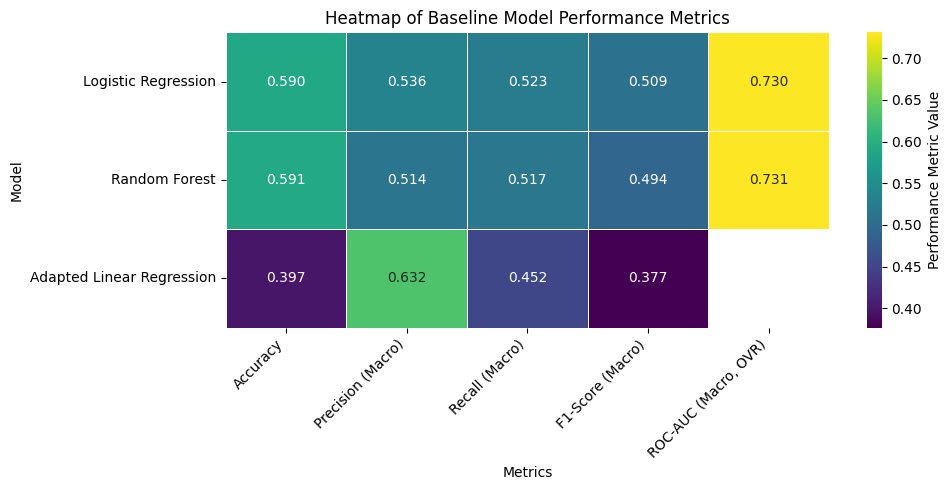

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data provided by the user
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Adapted Linear Regression'],
    'Accuracy': [0.5896, 0.5906, 0.3966],
    'Precision (Macro)': [0.5357, 0.5143, 0.6317],
    'Recall (Macro)': [0.5230, 0.5173, 0.4521],
    'F1-Score (Macro)': [0.5095, 0.4943, 0.3770],
    'ROC-AUC (Macro, OVR)': [0.7295, 0.7309, 'N/A']
}

results_df = pd.DataFrame(data)

# 1. Handle the 'N/A' entry for plotting
# Replace 'N/A' with NaN (Not a Number)
results_df['ROC-AUC (Macro, OVR)'] = results_df['ROC-AUC (Macro, OVR)'].replace('N/A', np.nan).astype(float)

# 2. Set 'Model' as the index for the heatmap
results_df = results_df.set_index('Model')

# 3. Create the heatmap
plt.figure(figsize=(10, 5))

# Use the 'viridis' colormap (darker color = higher value/better performance)
sns.heatmap(
    results_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    linewidths=.5,
    cbar_kws={'label': 'Performance Metric Value'}
)

plt.title('Heatmap of Baseline Model Performance Metrics')
plt.ylabel('Model')
plt.xlabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig('baseline_heatmap.png')